# Interacting With Data

In [1]:
from IPython.display import display, Image, HTML
from talktools import website, nbviewer

## Data exploration

Data exploration is an iterative process that involves repeated passes at visualization, interaction and computation:

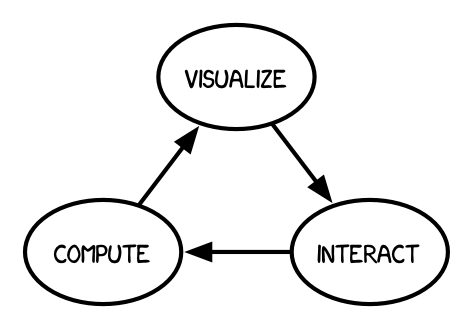

In [2]:
Image('images/VizInteractCompute.png')

Right now this cycle is still really painful:

* It takes too long to go through a single iteration
* Even when we are successful, the overall process is not reproducible
* Difficult to repeat, generalize or share with others
* Massive cognitive load that has nothing to do with extracting insight from the data

Jupyter and IPython include an architecture that allows kernels and JavaScript to communicate seamlessly and in real time.

## Interact

The Python kernel that ships with IPython 2.0 offers an `interact` function and decorator for interactive exploration. This is the highest-level API in our interactive JavaScript architecture. Other language kernels will also be able to implement these APIs.

### Image editing

In this example, we will perform some basic image processing using [scikit-image](http://scikit-image.org/).

In [9]:
from IPython.html.widgets import interact, fixed

In [10]:
import skimage
from skimage import data, filter, io

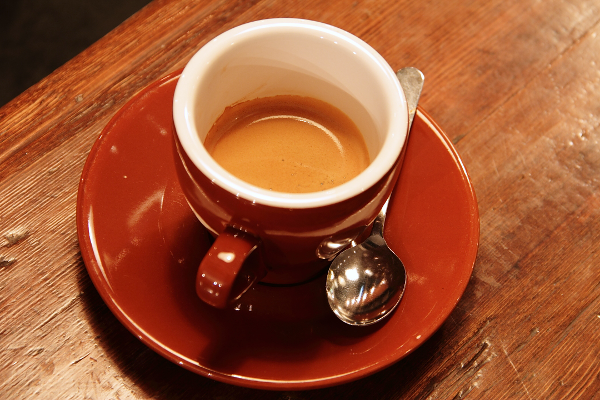

In [11]:
i = data.coffee()
io.Image(i)

Here is a function that can applies a Gaussian blur and adjusts the RGB channels:

In [12]:
def edit_image(image, sigma=0.1, r=1.0, g=1.0, b=1.0):
    new_image = filter.gaussian_filter(image, sigma=sigma, multichannel=True)
    new_image[:,:,0] = r*new_image[:,:,0]
    new_image[:,:,1] = g*new_image[:,:,1]
    new_image[:,:,2] = b*new_image[:,:,2]
    new_image = io.Image(new_image)
    display(new_image)
    return new_image

Calling the function once, displays and returns the edited image:

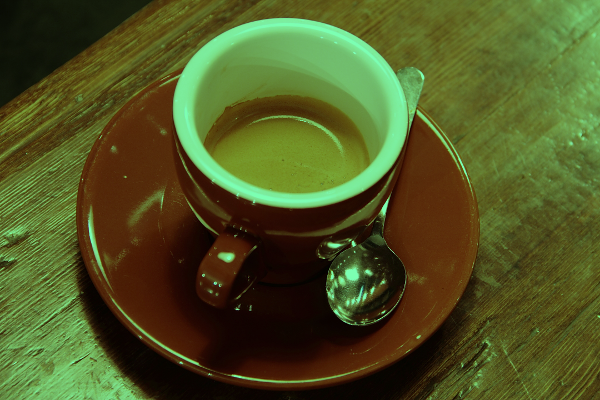

In [13]:
new_i = edit_image(i, 0.1, r=0.5, b=0.7);

We can use `interact` to explore the parameter space of the processed image:

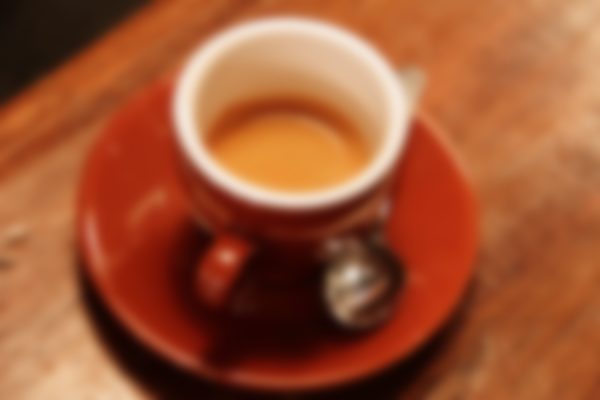

In [14]:
lims = (0.0,1.0,0.01)
interact(edit_image, image=fixed(i), sigma=(0.0,10.0,0.1), r=lims, g=lims, b=lims);

We can quickly interate through the visualize, interact, compute cycle.

### Symbolic mathematics

The `interact` function and the widget objects underneath it are completely generic and work with any type of Python code or output.

Here is an example from symbolic mathematics using the `sympy` library:

In [15]:
from sympy import Symbol, Eq, factor, init_printing
init_printing(use_latex='mathjax')

In [16]:
x = Symbol('x')

In [17]:
def factorit(n):
    display(Eq(x**n-1, factor(x**n-1)))

In [22]:
factorit(15)

 15               ⎛ 2        ⎞ ⎛ 4    3    2        ⎞ ⎛ 8    7    5    4    3 
x   - 1 = (x - 1)⋅⎝x  + x + 1⎠⋅⎝x  + x  + x  + x + 1⎠⋅⎝x  - x  + x  - x  + x  

       ⎞
- x + 1⎠

In [23]:
interact(factorit, n=(2,40));

 9               ⎛ 2        ⎞ ⎛ 6    3    ⎞
x  - 1 = (x - 1)⋅⎝x  + x + 1⎠⋅⎝x  + x  + 1⎠

## Statistics

Let's explore a 2d normal distribution:

$$
f_{\mathbf x}(x_1,\ldots,x_k) =
\frac{1}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}
\exp\left(-\frac{1}{2}({\mathbf x}-{\boldsymbol\mu})^T{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})
\right)
$$

$$
   \boldsymbol\mu = \begin{pmatrix} \mu_x \\ \mu_y \end{pmatrix}, \quad
    \boldsymbol\Sigma = \begin{pmatrix} \sigma_x^2 & \rho \sigma_x \sigma_y \\
                             \rho \sigma_x \sigma_y  & \sigma_y^2 \end{pmatrix}
$$

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [25]:
def normal_2d(n, mux, muy, sigmax, sigmay, corr):
    mean = [mux, muy]
    cov = [[sigmax**2, corr*sigmax*sigmay],[corr*sigmax*sigmay,sigmay**2]]
    d = np.random.multivariate_normal(mean, cov, n)
    return d[:,0], d[:,1]

In [26]:
x, y = normal_2d(100, 0.0, 0.0, 3.0, 2.0, 0.8)

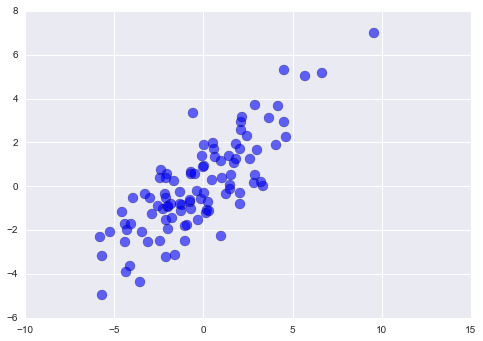

In [27]:
plt.scatter(x, y, s=100, alpha=0.6);

In [28]:
def plot_normal_2d(n, mux, muy, sigmax, sigmay, corr):
    x, y = normal_2d(n, mux, muy, sigmax, sigmay, corr)
    plt.scatter(x, y, s=100, alpha=0.6)
    plt.axis([-10.0,10.0,-10.0,10.0])

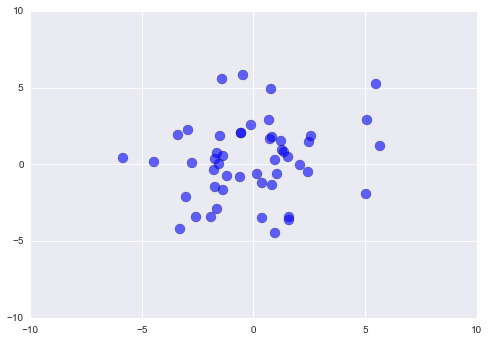

In [29]:
interact(plot_normal_2d, n=(10,100,10), mux=(-5.0,5.0,0.1), muy=(-5.0,5.0,0.1),
         sigmax=(0.01,5.0,0.01), sigmay=(0.01,5.0,0.01), corr=(-0.99,0.99,0.01));

## How does this work?

* The first argument to interact is a callable/function
* The keyword arguments to `interact` are "widget abbreviations"
* These "widget abbreviations" are converted to `Widget` instances
* These `Widget` objects are Python objects that are automatically synchronized with JavaScript MVC objects running in the browser
* `interact` simply calls its callable each time any widget changes state

In [30]:
def f(x):
    print x

In [31]:
interact(f, x=True);

True


In [32]:
interact(f, x=(0,10,2));

4


In [33]:
interact(f, x='Hi!');

Hi!


In [34]:
interact(f, x=dict(this=list, that=tuple, other=str));

<type 'list'>


## Architecture overview

The widget architecture in Jupyter and IPython has a layered design with each layer working independently of the others.

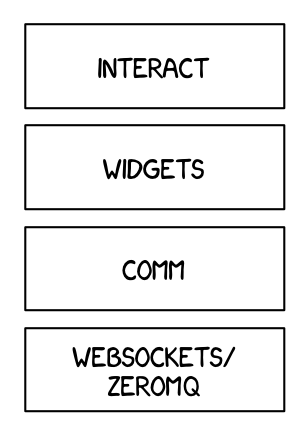

In [35]:
Image('images/WidgetArch.png')

* **Interact**: High-level interface for quick data exploration of a single callable/function.
* **Widgets**: Widgets synchronize reactive Python objects/models with JavaScript models using ([Backbone.js](http://backbonejs.org/)) and manage the lifecycle and parent/child relationships of JavaScript/HTML views. This layer is documented in [IPEP 23](https://github.com/ipython/ipython/wiki/IPEP-23%3A-Backbone.js-Widgets).
* **Comm**: The Comm layer allows real-time, asynchronous, bi-directional JSON messaging between Python objects in the kernel and JavaScript in the browser. Comm instances are very lightweight, with each Widget having its own Comm instance. This layer is documented in [IPEP 21](https://github.com/ipython/ipython/wiki/IPEP-21%3A-Widget-Messages).
* **WebSockets/ZeroMQ** At the lowest level, all Comm's share a pair of WebSocket/ZeroMQ connections to the notebook server and kernel. It is possibly to run all of this through a modern WebSocket aware proxy.

**This entire architecture is language agnostic.** Other language kernels (Julia, R, Scala, etc.) will be able to implement the kernel side of the architecture. This will allow all kernels to re-use the JavaScript/HTML/CSS side of the Widgets while having their own language specific APIs for interact/Widgets in the kernels.